## Setup

In [1]:
pwd

'/home/jake/Projects/mila/6759/cnn-downscaling/src/evaluation'

### Dependencies

In [2]:
cd /home/jake/Projects/mila/6759/cnn-downscaling/src/

/home/jake/Projects/mila/6759/cnn-downscaling/src


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import seaborn as sns

import torch
import torch.nn.functional as F

from training.data import WeatherBenchSuperresolutionDataModule
from training.models import LitSuperresolutionModelWrapper

In [5]:
plt.style.use('seaborn-pastel')
sns.set_style("ticks")

### Arguments

In [6]:
best_ckpt = "/home/jake/Projects/mila/6759/cnn-downscaling/logs/cnn/1uyqum0l/checkpoints/best_val_loss_epoch=0057.ckpt"

In [7]:
DATA_DIR = "../data/processed/temp/"
COARSE_SUB_DIR = "5625/temp_5625_processed.zarr"  # 5.625 degrees
FINE_SUB_DIR = "1406/temp_1406_processed.zarr"  # 1.402 degrees

### Data

In [8]:
data_module = WeatherBenchSuperresolutionDataModule(
    coarse_dir = os.path.join(DATA_DIR, COARSE_SUB_DIR),
    fine_dir = os.path.join(DATA_DIR, FINE_SUB_DIR),
    batch_size = 2922  # length of validation set
)

data_module.setup(stage=None)

val_dataloader = data_module.val_dataloader()
coarse_validation, fine_validation = iter(val_dataloader).next()

del val_dataloader

### Best Checkpoint

In [9]:
model = LitSuperresolutionModelWrapper.load_from_checkpoint(best_ckpt)

model.eval()

LitSuperresolutionModelWrapper(
  (model): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Conv2d(5, 21, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (3): ReLU()
    (4): Conv2d(21, 55, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (5): ReLU()
    (6): Conv2d(55, 144, kernel_size=(3, 3), stride=(1, 1), padding=valid)
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=14400, out_features=2592, bias=True)
    (10): Linear(in_features=2592, out_features=1344, bias=True)
    (11): Linear(in_features=1344, out_features=4096, bias=True)
    (12): Unflatten(dim=1, unflattened_size=(64, 64))
  )
  (loss): MSELoss()
)

### Generate Validation Set Predictions

In [10]:
preds_validation = model(coarse_validation)
preds_validation.shape

torch.Size([2922, 64, 64])

## Evaluation Metrics

In [11]:
torch.set_grad_enabled(False);

#### MSE

In [12]:
mse = F.mse_loss(preds_validation, fine_validation)
mse  # aligns with https://wandb.ai/6759-proj/cnn/runs/1uyqum0l

tensor(1.8316)

In [13]:
daily_mses = torch.mean((preds_validation - fine_validation)**2, dim=(1,2))
torch.mean(daily_mses)

tensor(1.8316)

#### Correlation

In [14]:
pred_demeaned = (preds_validation - preds_validation.mean(axis=(1,2), keepdims=True))
true_demeaned = (fine_validation - fine_validation.mean(axis=(1,2), keepdims=True))

daily_corrs = \
    torch.sum(pred_demeaned*true_demeaned, axis=(1,2)) / \
    (torch.sqrt(torch.sum(pred_demeaned ** 2, axis=(1,2))) * torch.sqrt(torch.sum(true_demeaned ** 2, axis=(1,2))))

del pred_demeaned, true_demeaned

print(daily_corrs.min(), daily_corrs.mean(), daily_corrs.max())

tensor(0.9894) tensor(0.9960) tensor(0.9984)


#### Bias

In [15]:
preds_p02 = torch.quantile(preds_validation.reshape(preds_validation.shape[0], -1), dim=1, q=.02)
preds_p98 = torch.quantile(preds_validation.reshape(preds_validation.shape[0], -1), dim=1, q=.98)

fine_p02 = torch.quantile(fine_validation.reshape(preds_validation.shape[0], -1), dim=1, q=.02)
fine_p98 = torch.quantile(fine_validation.reshape(preds_validation.shape[0], -1), dim=1, q=.98)

In [16]:
daily_biases_mean =  preds_validation.mean(axis=(1,2)) - fine_validation.mean(axis=(1,2))
daily_biases_p02 = preds_p02 - fine_p02
daily_biases_p98 = preds_p98 - fine_p98

#### TXx, TXn (Monthly)

In [17]:
train_dates, val_dates, test_dates = data_module.split_date_ranges

In [18]:
validation_pdf = pd.DataFrame(
    fine_validation.flatten(),
    index=data_module.fine.loc[val_dates[0]:val_dates[-1]].index,
    columns=["temp_true"]
)
validation_pdf["temp_pred"] = preds_validation.flatten()

In [19]:
validation_tx = validation_pdf.groupby(
    [validation_pdf.index.get_level_values("date").to_period('M'), "lat", "lon"]
).agg({
    "temp_true": [np.max, np.min],
    "temp_pred": [np.max, np.min],
})

validation_tx.columns = ["true_txx", "true_txn", "pred_txx", "pred_txn"]

In [20]:
validation_tx["bias_txx"] = validation_tx["pred_txx"] - validation_tx["true_txx"]
validation_tx["bias_txn"] = validation_tx["pred_txn"] - validation_tx["true_txn"]

#### Stability

In [21]:
preds_std = torch.std(preds_validation, dim=(1,2))
fine_std = torch.std(fine_validation, dim=(1,2))

In [22]:
daily_stability = preds_std / fine_std

## Evaluation Analysis

### Aggregate Daily Results

In [23]:
train_dates, val_dates, test_dates = data_module.split_date_ranges

In [24]:
eval_metrics = pd.DataFrame(
    {
        'mse' : daily_mses,
        'corr' : daily_corrs,
        'bias_p02' : daily_biases_p02,
        'bias_mean' : daily_biases_mean,
        'bias_p98' : daily_biases_p98,
        'stability' : daily_stability,
    },
    index = val_dates
)

In [25]:
eval_metrics.head(3)

,mse,corr,bias_p02,bias_mean,bias_p98,stability
date,,,,,,
2007-01-01,1.808680,0.997427,1.394960,0.088339,-0.305513,0.986853
2007-01-02,1.869309,0.997387,0.690262,0.106557,-0.188805,0.995797
2007-01-03,1.955675,0.997378,0.855354,0.011604,-0.776031,0.990021


### Error Distribution

In [26]:
shared_line_kwargs = {"alpha": .67, "linestyle": "dashed", "linewidth": 2}
pctiles_extremes = [.02, .05, .1, .5, .9, .95, .98]

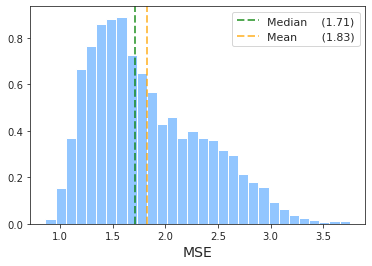

In [27]:
ax = eval_metrics['mse'].hist(bins=30, density=True, figsize=(6,4));

summary = eval_metrics['mse'].describe(percentiles=[]).round(2)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("MSE", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

#### Daily Bias Distributions

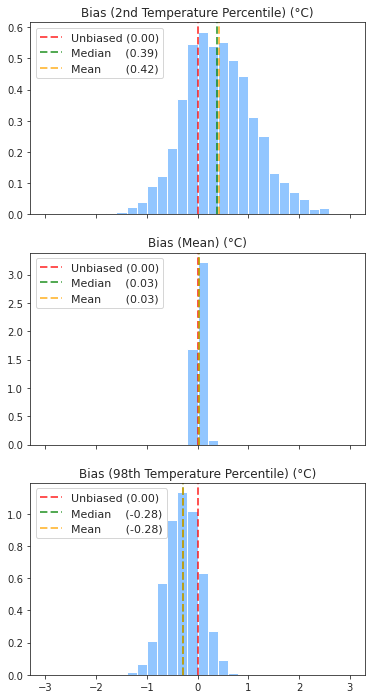

In [28]:
fig, axes =  plt.subplots(3, 1, figsize=(6,12), sharex=True)

measure_and_column = zip(
    [f"Bias ({loc}) (°C)" for loc in ["2nd Temperature Percentile", "Mean", "98th Temperature Percentile"]],
    ['bias_p02', 'bias_mean', 'bias_p98']
)

for i, (measure, col) in enumerate(measure_and_column):
    axes[i].hist(eval_metrics[col], range=(-3,3), bins=30, density=True, label=None)

    # summary statistics
    summary = eval_metrics[col].describe(percentiles=[]).round(2)
    axes[i].axvline(0, color="red", label="Unbiased (0.00)", **shared_line_kwargs)
    axes[i].axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
    axes[i].axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

    # labels
    axes[i].set_title(measure)
    axes[i].legend(loc="upper left", fontsize=11)

### Stability Distribution

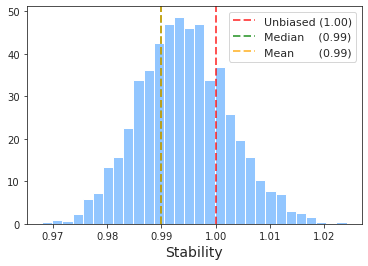

In [29]:
ax = eval_metrics['stability'].hist(bins=30, density=True, figsize=(6,4));

summary = eval_metrics['stability'].describe(percentiles=[]).round(2)
ax.axvline(1, color="red", label="Unbiased (1.00)", **shared_line_kwargs)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("Stability", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

### Monthly TXx, TXn Bias
#### Distribution
_each contribution is a calendar month (`yyyy-mm`)_

count    393216.00
mean         -0.28
std           1.14
min         -14.95
2%           -3.09
5%           -2.23
10%          -1.58
50%          -0.20
90%           0.88
95%           1.41
98%           2.15
max          13.18
Name: bias_txx, dtype: float64


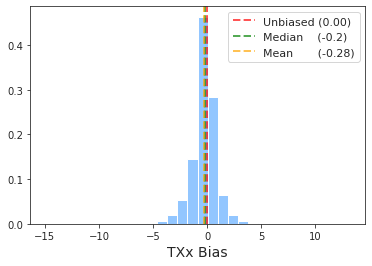

In [30]:
ax = validation_tx["bias_txx"].hist(bins=30, density=True, figsize=(6,4));

summary = validation_tx["bias_txx"].describe(percentiles=pctiles_extremes).round(2)
ax.axvline(0, color="red", label="Unbiased (0.00)", **shared_line_kwargs)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("TXx Bias", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

print(summary)

count    393216.00
mean          0.49
std           1.26
min          -8.18
2%           -1.90
5%           -1.20
10%          -0.72
50%           0.30
90%           2.02
95%           2.80
98%           3.85
max          15.18
Name: bias_txn, dtype: float64


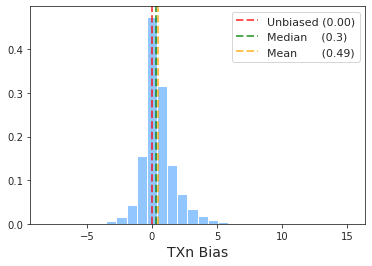

In [31]:
ax = validation_tx["bias_txn"].hist(bins=30, density=True, figsize=(6,4));

summary = validation_tx["bias_txn"].describe(percentiles=pctiles_extremes).round(2)
ax.axvline(0, color="red", label="Unbiased (0.00)", **shared_line_kwargs)
ax.axvline(summary['50%'], color="green", label = f"Median    ({summary['50%']})", **shared_line_kwargs)
ax.axvline(summary['mean'], color="orange", label = f"Mean       ({summary['mean']})", **shared_line_kwargs)

ax.set_xlabel("TXn Bias", fontsize=14);
ax.legend(loc="upper right", fontsize=11);
plt.grid(False)

print(summary)

#### By Month

In [32]:
tx_avg_bias_by_month = validation_tx[["bias_txn", "bias_txx"]].groupby(
    validation_tx.index.get_level_values("date").month
).agg({
    "bias_txn": [np.mean, np.std],
    "bias_txx": [np.mean, np.std],
})

tx_avg_bias_by_month.columns = ["bias_txn_mean", "bias_txn_std", "bias_txx_mean", "bias_txx_std"]

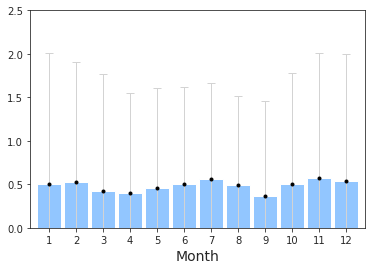

In [33]:
ax = tx_avg_bias_by_month["bias_txn_mean"].plot.bar(figsize=(6,4), width=.9);
plt.errorbar(
    x = list(range(0,11+1)),
    y = tx_avg_bias_by_month["bias_txn_mean"],
    yerr = tx_avg_bias_by_month["bias_txn_std"],
    fmt = ".k", ecolor='lightgray', elinewidth=1, capsize=4
);

plt.ylim(0,2.5);
plt.xticks(rotation=0);
ax.set_xlabel("Month", fontsize=14);

#### Average by Geography

In [34]:
tx_avg_bias_by_geo = validation_tx.groupby(["lat", "lon"])[["bias_txx", "bias_txn"]].mean()

In [35]:
latitudes = data_module.fine.index.levels[1].to_series()
longitudes = data_module.fine.index.levels[2].to_series()

m = Basemap(projection='ortho', lat_0=30 ,lon_0=-100, resolution='l')
x, y = m(*np.meshgrid(longitudes-180,latitudes))

Charts below indicate a slight tendency for the superresolution CNN to capture temperature maximums (TXx) in South America. This makes sense because the patterns learned in North America likely do not apply in the South.

More notably, we can see the CNN's tendency to on average _under_estimate minimum monthly temperatures (TXn) across the full geography. 

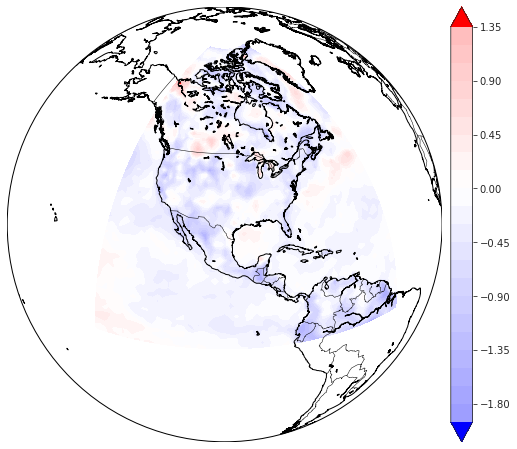

In [36]:
cs = m.contourf(
    x, y,
    tx_avg_bias_by_geo["bias_txx"].unstack("lon").values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-5, vmax=5, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

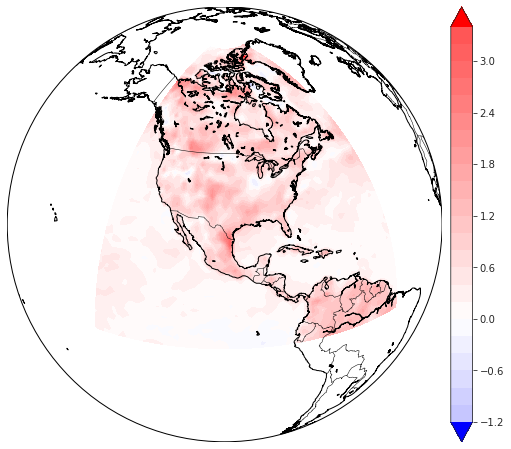

In [37]:
cs = m.contourf(
    x, y,
    tx_avg_bias_by_geo["bias_txn"].unstack("lon").values,  # 64 x 64
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-5, vmax=5, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

### Errors by Geography

In [27]:
abs_error = (preds_validation - fine_validation)

In [28]:
latitudes = data_module.fine.index.levels[1].to_series()
longitudes = data_module.fine.index.levels[2].to_series()

In [29]:
m = Basemap(projection='ortho', lat_0=30 ,lon_0=-100, resolution='l')
x, y = m(*np.meshgrid(longitudes-180,latitudes))

#### Random Average Day

In [31]:
random_average_day = eval_metrics[eval_metrics['mse'].between(1.5,2)].index.to_series().sample(1, random_state=1729).iloc[0]

index_in_val = val_dates.get_loc(random_average_day)

eval_metrics.loc[random_average_day]

mse          1.534719
corr         0.994895
bias_p02    -0.063440
bias_mean   -0.033041
bias_p98    -0.907557
stability    0.985743
Name: 2011-05-26 00:00:00, dtype: float32

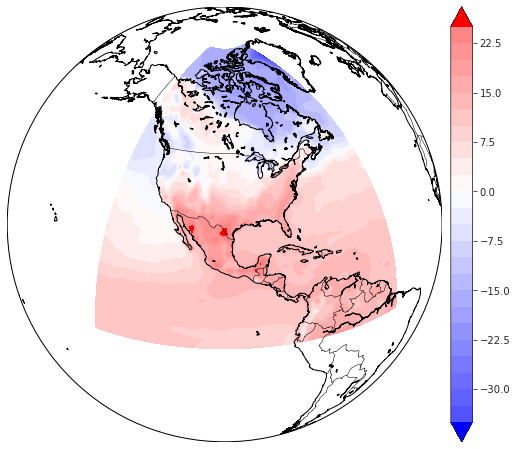

In [32]:
cs = m.contourf(
    x, y,
    fine_validation[index_in_val,...],
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

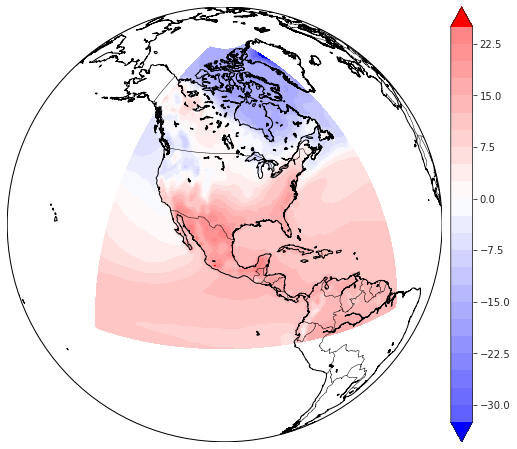

In [33]:
cs = m.contourf(
    x, y,
    preds_validation[index_in_val,...],
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

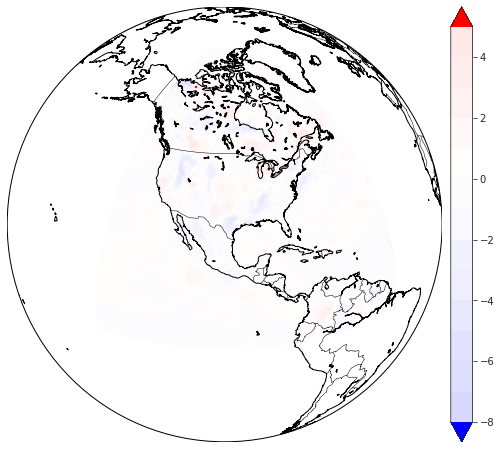

In [34]:
cs = m.contourf(
    x, y,
    abs_error[index_in_val,...],
    levels=16, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

#### Poor-Performing Day

In [35]:
random_bad_day = eval_metrics[eval_metrics['mse'].between(3,3.5)].index.to_series().sample(1, random_state=1729).iloc[0]

index_in_val = val_dates.get_loc(random_bad_day)

eval_metrics.loc[random_bad_day]

mse          3.162660
corr         0.996680
bias_p02     2.402092
bias_mean    0.091243
bias_p98    -0.966814
stability    0.987539
Name: 2011-02-26 00:00:00, dtype: float32

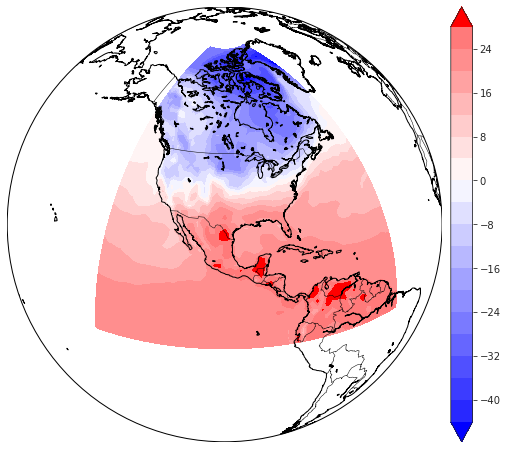

In [36]:
cs = m.contourf(
    x, y,
    fine_validation[index_in_val,...],
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

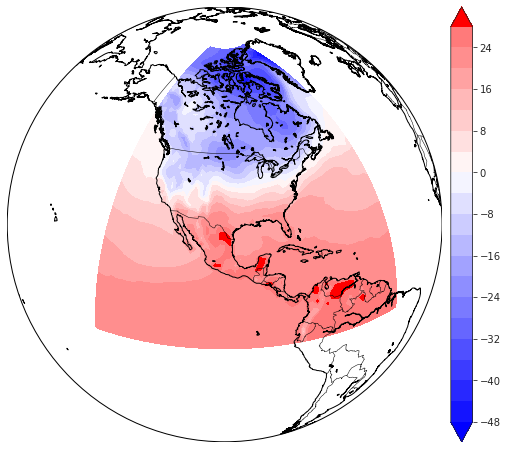

In [37]:
cs = m.contourf(
    x, y,
    preds_validation[index_in_val,...],
    levels=24, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();

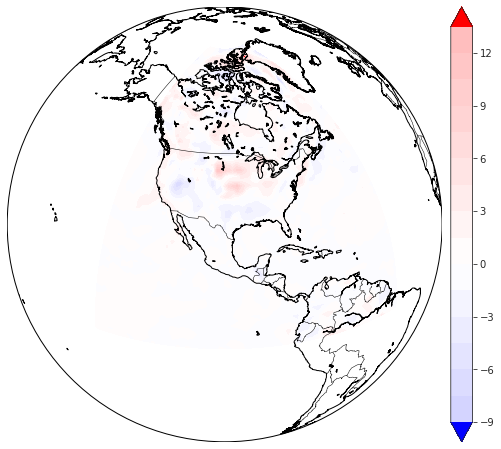

In [38]:
cs = m.contourf(
    x, y,
    abs_error[index_in_val,...],
    levels=16, alpha=1,
    cmap = 'bwr', vmin=-50, vmax=50, extend='both'
)

m.drawcoastlines()
m.drawcountries()

plt.gcf().set_size_inches(16, 8)
m.colorbar();